Please upload your Superstore sales CSV file (e.g., superstore_sales.csv):


Saving Superstore - store analysis.csv to Superstore - store analysis (3).csv
Dataset Preview:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  11-08-2016  11-11-2016    Second Class    CG-12520   
1       2  CA-2016-152156  11-08-2016  11-11-2016    Second Class    CG-12520   
2       3  CA-2016-138688  06-12-2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10-11-2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10-11-2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/yphdkkcv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/3x992ocn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4436', 'data', 'file=/tmp/tmp14p5wrz5/yphdkkcv.json', 'init=/tmp/tmp14p5wrz5/3x992ocn.json', 'output', 'file=/tmp/tmp14p5wrz5/prophet_modelm4yzkgf1/prophet_model-20250205074426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


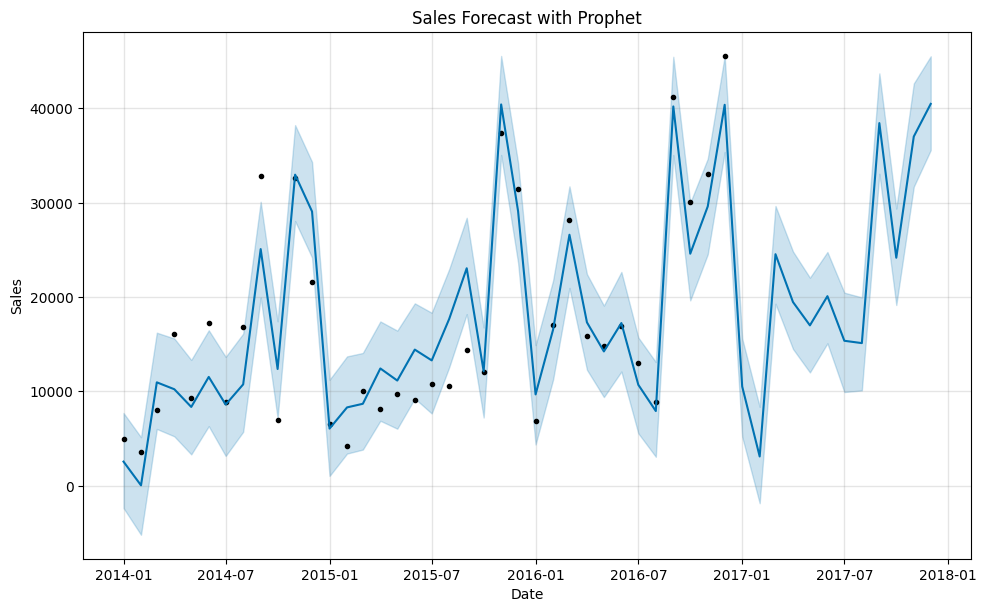

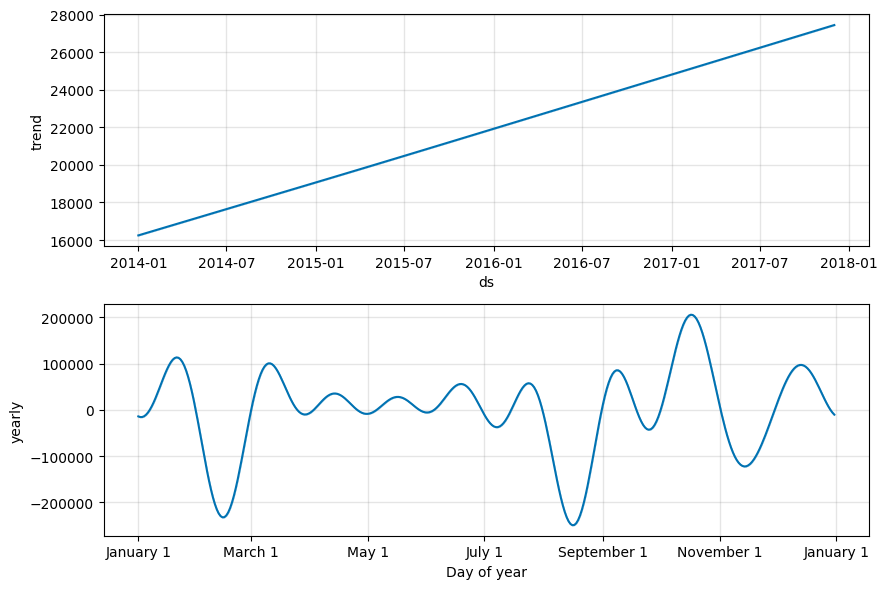

Forecast Evaluation Metrics:
MAPE: 22.93%
RMSE: 5504.81
Merged Actual vs. Forecasted Sales:
           ds           y          yhat
0  2017-01-01  11076.9750  10524.464239
1  2017-02-01   7278.1000   3105.160418
2  2017-03-01  10997.7420  24552.629897
3  2017-04-01  18896.3015  19478.069554
4  2017-05-01  19357.8208  17003.972636
5  2017-06-01  17888.3560  20100.011605
6  2017-07-01  15992.8080  15371.269256
7  2017-08-01  14269.2740  15122.789300
8  2017-09-01  36850.9140  38450.819523
9  2017-10-01  29834.0830  24176.808095
10 2017-11-01  47347.7850  37025.110983
11 2017-12-01  43517.1250  40488.321156


In [ ]:
# ============================
# 1. Package Installation & Imports
# ============================
# Install necessary packages (if not already installed)
!pip install --quiet prophet matplotlib pandas scikit-learn

# Import libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================
# 2. Loading the Dataset from Google Colab
# ============================
print("Please upload your Superstore sales CSV file (e.g., superstore_sales.csv):")
uploaded = files.upload()  # Use the file selector to upload your CSV file
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin-1')

# Display the first few rows
print("Dataset Preview:")
print(df.head())

# ============================
# 3. Preprocessing & Cleaning the Data
# ============================
# Ensure the 'Order Date' column is parsed as a datetime type.
# (Adjust the column name if necessary.)
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Handle missing values: Drop rows where Order Date or Sales are missing.
df = df.dropna(subset=['Order Date', 'Sales'])

# Optionally, you can also fill or drop other missing values.
# For our analysis, we focus on the Order Date and Sales columns.

# ============================
# 4. Aggregating Sales Data by Date
# ============================
# We aggregate sales on a monthly basis. (Frequency 'MS' gives Month Start)
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='MS'))['Sales'].sum().reset_index()

# Prophet requires the DataFrame to have columns 'ds' (date) and 'y' (value)
monthly_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'}, inplace=True)

# Display aggregated data preview
print("Monthly Sales Data Preview:")
print(monthly_sales.head())

# ============================
# 5. Splitting Data into Training and Test Sets
# ============================
# For evaluation, we use the last 12 months as the test set.
if len(monthly_sales) < 24:
    raise ValueError("Not enough data for splitting into training and testing sets. Need at least 24 months.")

train = monthly_sales.iloc[:-12]  # training data: all but the last 12 months
test = monthly_sales.iloc[-12:]   # test data: last 12 months

print("Training data period:", train['ds'].min(), "to", train['ds'].max())
print("Test data period:", test['ds'].min(), "to", test['ds'].max())

# ============================
# 6. Training the Prophet Model
# ============================
model = Prophet()  # You can customize seasonality and holidays if needed.
model.fit(train)

# ============================
# 7. Forecasting Future Sales for the Next 12 Months
# ============================
# Create a DataFrame for future dates: 12 months into the future (monthly frequency)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# ============================
# 8. Plotting Trends, Seasonality, and Predictions
# ============================
# Plot forecast (this includes the forecasted values and uncertainty intervals)
fig1 = model.plot(forecast)
plt.title("Sales Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Plot forecast components (trend, yearly seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()

# ============================
# 9. Evaluating Forecast Accuracy using MAPE & RMSE
# ============================
# Extract forecast for the test period only (last 12 months)
forecast_test = forecast[['ds', 'yhat']].tail(12)

# Merge the forecast with actual test data on date
merged = test.merge(forecast_test, on='ds', how='left')

# Calculate evaluation metrics
# MAPE: Mean Absolute Percentage Error
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100
# RMSE: Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print("Forecast Evaluation Metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

# Optionally, display the merged table for further inspection
print("Merged Actual vs. Forecasted Sales:")
print(merged)


Please upload your Superstore sales CSV file (e.g., superstore_sales.csv):


DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/sd05h_eg.json


Saving Superstore - store analysis.csv to Superstore - store analysis (5).csv
Dataset Preview:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  11-08-2016  11-11-2016    Second Class    CG-12520   
1       2  CA-2016-152156  11-08-2016  11-11-2016    Second Class    CG-12520   
2       3  CA-2016-138688  06-12-2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10-11-2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10-11-2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  

DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/jc4d3f26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47281', 'data', 'file=/tmp/tmp14p5wrz5/sd05h_eg.json', 'init=/tmp/tmp14p5wrz5/jc4d3f26.json', 'output', 'file=/tmp/tmp14p5wrz5/prophet_modelsne2kf7s/prophet_model-20250205074911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


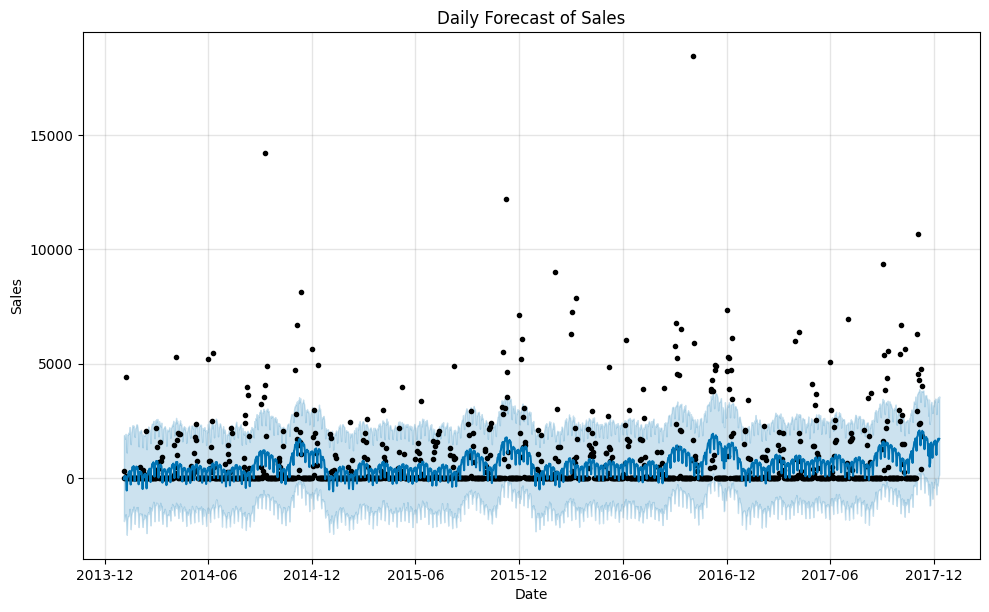

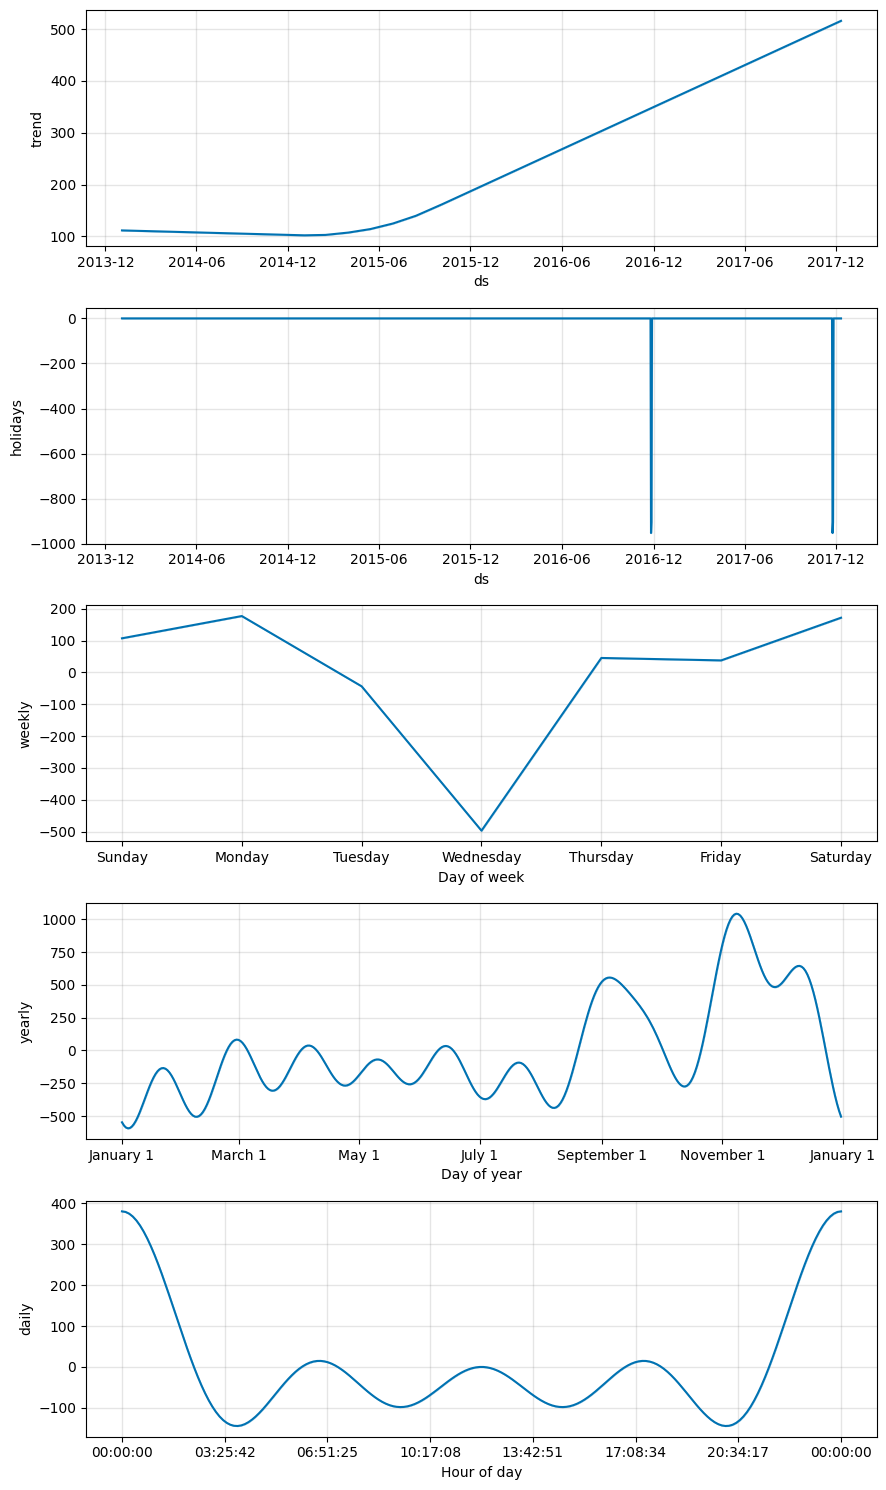

DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/o4tc8cv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/a1aj4tu7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85212', 'data', 'file=/tmp/tmp14p5wrz5/o4tc8cv8.json', 'init=/tmp/tmp14p5wrz5/a1aj4tu7.json', 'output', 'file=/tmp/tmp14p5wrz5/prophet_modelodgi41d1/prophet_model-20250205074913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Daily Forecast Evaluation:
MAPE: inf%
RMSE: 2487.93

----- WEEKLY FORECAST -----

Weekly Data: Training period from 2014-01-05 to 2017-09-24
Test period: 2017-10-01 to 2017-12-17


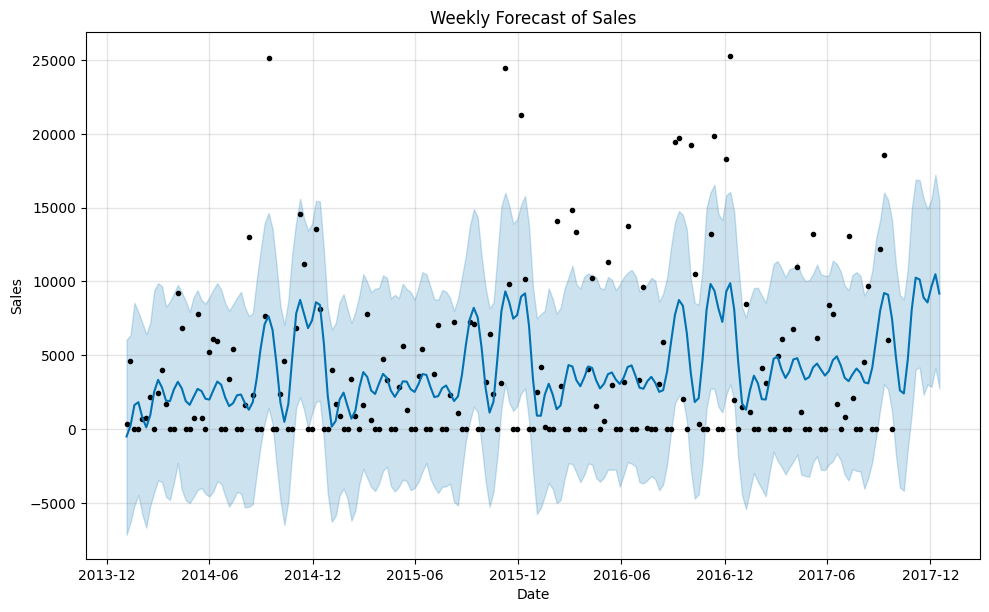

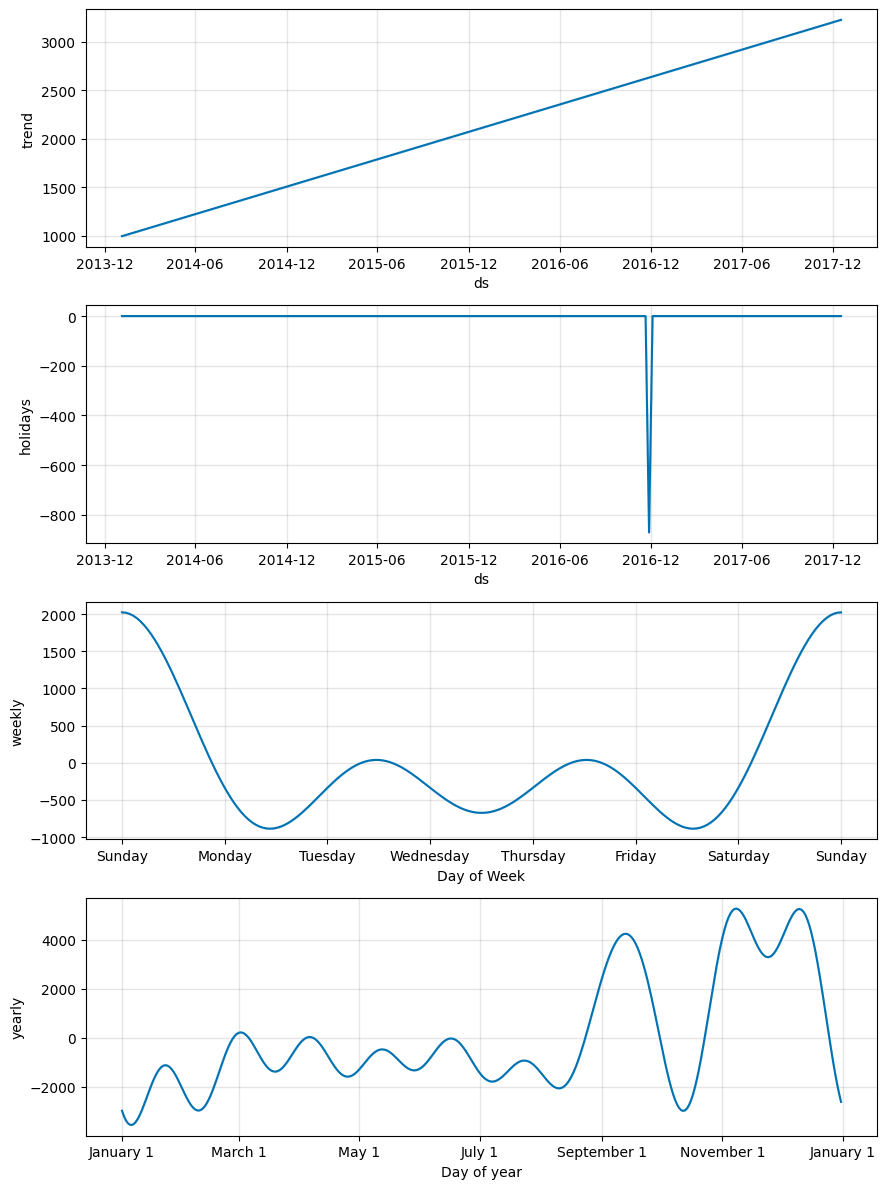

DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/amfmr3kv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp14p5wrz5/29t_y4tz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4769', 'data', 'file=/tmp/tmp14p5wrz5/amfmr3kv.json', 'init=/tmp/tmp14p5wrz5/29t_y4tz.json', 'output', 'file=/tmp/tmp14p5wrz5/prophet_model2ro5rl2d/prophet_model-20250205074914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:49:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Weekly Forecast Evaluation:
MAPE: inf%
RMSE: 10034.09

----- MONTHLY FORECAST -----

Monthly Data: Training period from 2014-01-01 to 2016-12-01
Test period: 2017-01-01 to 2017-12-01


07:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


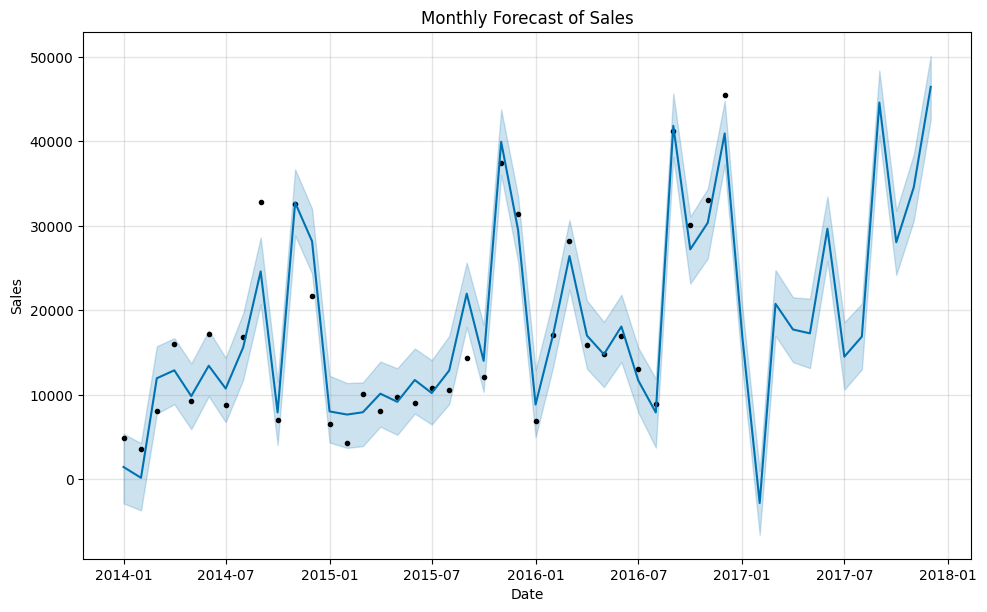

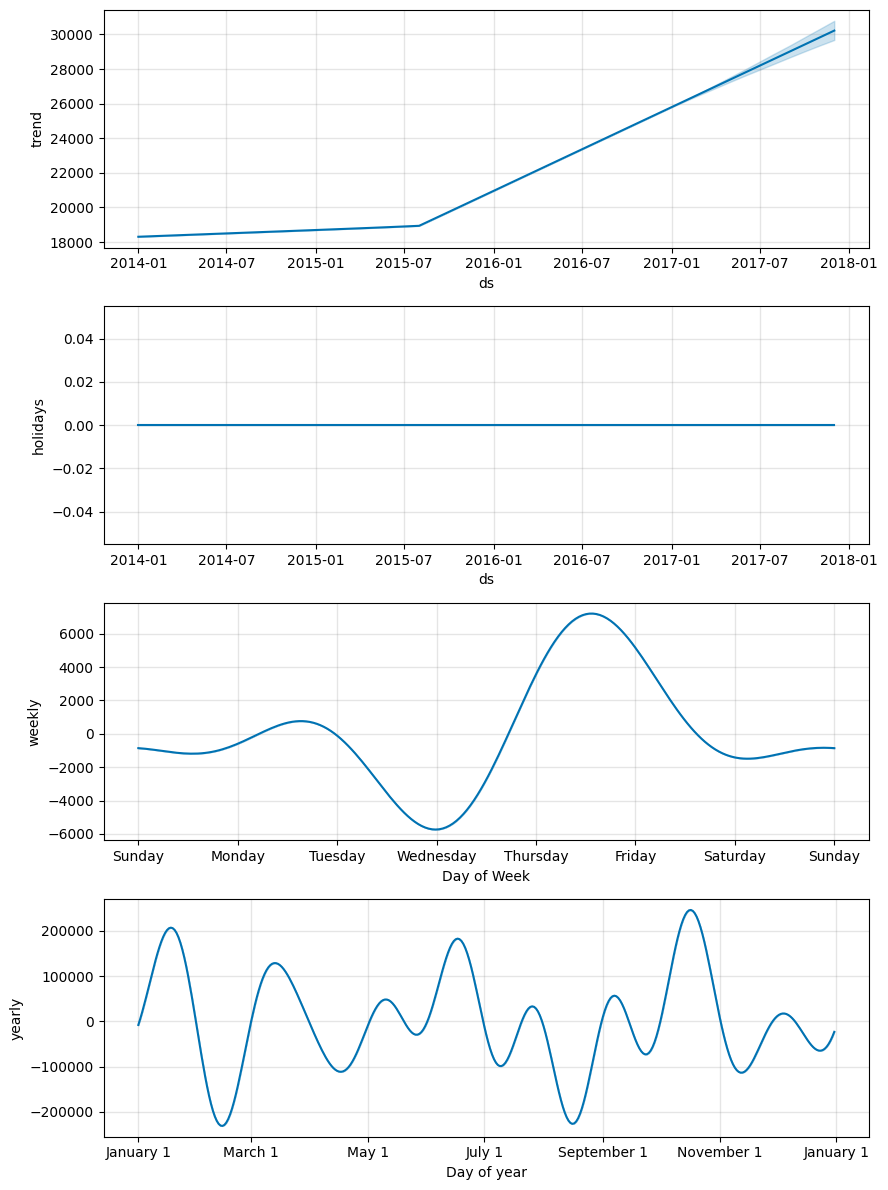

Monthly Forecast Evaluation:
MAPE: 37.68%
RMSE: 7190.59



In [ ]:
# ============================
# 0. Package Installation & Imports
# ============================
!pip install --quiet prophet matplotlib pandas scikit-learn seaborn

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime

# ============================
# 1. Load and Preprocess the Dataset
# ============================
print("Please upload your Superstore sales CSV file (e.g., superstore_sales.csv):")
uploaded = files.upload()  # Use file selector to upload your CSV file
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin-1')

# Preview the data
print("Dataset Preview:")
print(df.head())

# Convert 'Order Date' to datetime. (Adjust the column name if needed.)
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Drop rows with missing Order Date or Sales
df = df.dropna(subset=['Order Date', 'Sales'])

# ============================
# 2. Define a Function to Forecast Sales by Aggregation Frequency
# ============================
def forecast_sales(data, freq, forecast_periods, period_label):
    """
    Aggregates sales data at a specified frequency, fits a Prophet model,
    forecasts future sales, plots forecast and decomposed components,
    and evaluates forecast accuracy.

    Parameters:
      data             : DataFrame containing at least 'Order Date' and 'Sales'
      freq             : Frequency string for aggregation ('D' for daily, 'W' for weekly, 'MS' for monthly)
      forecast_periods : Number of periods to forecast (e.g., 30 days, 12 weeks, or 12 months)
      period_label     : A descriptive label (e.g., "Daily", "Weekly", "Monthly")

    Returns:
      forecast         : Prophet forecast DataFrame for the full period (history + forecast)
      merged           : DataFrame merging actual test data with forecasted values for evaluation
    """
    # --- 2.1 Aggregate Sales Data by the Given Frequency ---
    agg_data = data.groupby(pd.Grouper(key='Order Date', freq=freq))['Sales'].sum().reset_index()
    agg_data.rename(columns={'Order Date': 'ds', 'Sales': 'y'}, inplace=True)
    agg_data.sort_values('ds', inplace=True)

    # --- 2.2 Create a Holiday DataFrame (Example) ---
    # For demonstration, we include a few example holiday dates.
    # You can customize this DataFrame based on your region and business.
    holiday_dates = ['2016-11-26', '2017-11-24', '2018-11-23', '2019-11-29']
    holidays = pd.DataFrame({
        'holiday': 'holiday_effect',
        'ds': pd.to_datetime(holiday_dates),
        'lower_window': 0,
        'upper_window': 1,
    })

    # --- 2.3 Split Data into Training and Test Sets ---
    # For evaluation, we reserve the last portion as the test set.
    # For daily: use last 30 days, weekly: last 12 weeks, monthly: last 12 months.
    if freq == 'D':
        test_periods = 30
    elif freq == 'W':
        test_periods = 12
    elif freq == 'MS':
        test_periods = 12
    else:
        test_periods = forecast_periods

    if len(agg_data) <= test_periods:
        raise ValueError(f"Not enough data for {period_label} forecasting. Need more data.")

    train = agg_data.iloc[:-test_periods]
    test  = agg_data.iloc[-test_periods:]

    print(f"\n{period_label} Data: Training period from {train['ds'].min().date()} to {train['ds'].max().date()}")
    print(f"Test period: {test['ds'].min().date()} to {test['ds'].max().date()}")

    # --- 2.4 Fit the Prophet Model ---
    # Enable seasonality based on frequency: daily data may use daily seasonality.
    m = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=(freq=='D'))
    m.fit(train)

    # --- 2.5 Forecast Future Sales ---
    future = m.make_future_dataframe(periods=forecast_periods, freq=freq)
    forecast = m.predict(future)

    # --- 2.6 Plot Forecast and Components ---
    fig1 = m.plot(forecast)
    plt.title(f"{period_label} Forecast of Sales")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.show()

    fig2 = m.plot_components(forecast)
    plt.show()

    # --- 2.7 Evaluate Forecast Accuracy ---
    # Evaluate only on the test period.
    forecast_test = forecast[['ds', 'yhat']].iloc[-test_periods:]
    merged = test.merge(forecast_test, on='ds', how='left')

    mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100
    rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

    print(f"{period_label} Forecast Evaluation:")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}\n")

    return forecast, merged

# ============================
# 3. Forecast on Daily, Weekly, and Monthly Basis
# ============================
# Daily Forecast: forecast the next 30 days
print("----- DAILY FORECAST -----")
forecast_daily, merged_daily = forecast_sales(df, freq='D', forecast_periods=30, period_label="Daily")

# Weekly Forecast: forecast the next 12 weeks
print("----- WEEKLY FORECAST -----")
forecast_weekly, merged_weekly = forecast_sales(df, freq='W', forecast_periods=12, period_label="Weekly")

# Monthly Forecast: forecast the next 12 months
print("----- MONTHLY FORECAST -----")
forecast_monthly, merged_monthly = forecast_sales(df, freq='MS', forecast_periods=12, period_label="Monthly")
